In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import range
import os

import logging
logging.basicConfig(level=logging.DEBUG)

import sys
#sys.stdout = sys.stderr
# Prevent reaching to maximum recursion depth in `theano.tensor.grad`
#sys.setrecursionlimit(2 ** 20)

import numpy as np
np.random.seed(2 ** 10)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, Input, Activation, Add, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K


# ================================================
# DATA CONFIGURATION:
logging.debug("Loading data...")

nb_classes = 1000
image_size = 32

X_train = np.load('WMx_train.npy')
y_train =np.load('WMy_train.npy')
X_test  =np.load('x_test.npy')
y_test  =np.load('y_test.npy')
X_train = X_train.astype('float32')/ 255
X_test = X_test.astype('float32')/ 255

# convert class vectors to binary class matrices
#y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)
print('trainshape:',X_train.shape, y_train.shape)
print('testshape:',X_test.shape, y_test.shape)
# ================================================

# ================================================
# NETWORK/TRAINING CONFIGURATION:
logging.debug("Loading network/training configuration...")

depth = 16             # table 5 on page 8 indicates best value (4.17) CIFAR-10
k = 8                  # 'widen_factor'; table 5 on page 8 indicates best value (4.17) CIFAR-10
dropout_probability = 0 # table 6 on page 10 indicates best value (4.17) CIFAR-10

weight_decay =  5e-4   # page 10: "Used in all experiments"

batch_size = 128        # page 8: "Used in all experiments"
# Regarding nb_epochs, lr_schedule and sgd, see bottom page 10:
nb_epochs = 80
lr_schedule = [40, 60, 90] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.1
    elif (epoch_idx + 1) < lr_schedule[1]:
        return 0.1*0.1 # lr_decay_ratio = 0.2
    elif (epoch_idx + 1) < lr_schedule[2]:
        return 0.1*0.1*0.1
    return 0.1*0.1*0.1*0.1
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)

# Other config from code; throughtout all layer:
use_bias = False        # following functions 'FCinit(model)' and 'DisableBias(model)' in utils.lua
weight_init="he_normal" # follows the 'MSRinit(model)' function in utils.lua

# Keras specific
if K.image_data_format() == "th":
    logging.debug("image_dim_ordering = 'th'")
    channel_axis = 1
    input_shape = (3, image_size, image_size)
else:
    logging.debug("image_dim_ordering = 'tf'")
    channel_axis = -1
    input_shape = (image_size, image_size, 3)
# ================================================

# ================================================
# OUTPUT CONFIGURATION:
print_model_summary = True
save_model = True
save_model_plot = False

MODEL_PATH = os.environ.get('MODEL_PATH', 'models/')
CHECKPOINT_PATH = os.environ.get('CHECKPOINT_PATH', 'checkpoints/')
# ================================================


# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis)(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis)(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=l2(weight_decay),
                                use_bias=use_bias)(convs)
            else:
                convs = BatchNormalization(axis=channel_axis)(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability)(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=l2(weight_decay),
                                use_bias=use_bias)(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=l2(weight_decay),
                              use_bias=use_bias)(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


def create_model():
    logging.debug("Creating model...")
    
    #assert((depth - 4) % 6 == 0)
    n = (depth - 4) // 6
    
    inputs = Input(shape=input_shape)

    n_stages=[16, 16*k, 32*k, 64*k]


    conv1 = Conv2D(n_stages[0], 
                    (3, 3), 
                    strides=1,
                    padding="same",
                    kernel_initializer=weight_init,
                    kernel_regularizer=l2(weight_decay),
                    use_bias=use_bias)(inputs) # "One conv at the beginning (spatial size: 32x32)"

    # Add wide residual blocks
    block_fn = _wide_basic
    conv2 = _layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1))(conv1)# "Stage 1 (spatial size: 32x32)"
    conv3 = _layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2))(conv2)# "Stage 2 (spatial size: 16x16)"
    conv4 = _layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2))(conv3)# "Stage 3 (spatial size: 8x8)"

    batch_norm = BatchNormalization(axis=channel_axis)(conv4)
    relu = Activation("relu")(batch_norm)
                                            
    # Classifier block
    pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
    flatten = Flatten()(pool)
    predictions = Dense(units=nb_classes, kernel_initializer=weight_init, use_bias=use_bias,
                        kernel_regularizer=l2(weight_decay), activation="softmax")(flatten)

    model = Model(inputs=inputs, outputs=predictions)
    return model


if __name__ == '__main__':
    model = create_model()
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])

    if print_model_summary:
        logging.debug("Model summary...")
        model.count_params()
        model.summary()

    if save_model_plot:
        logging.debug("Saving model plot...")
        from tensorflow.keras.utils import plot_model
        
    # Data Augmentation based on page 6 (see README for full details)
    logging.debug("Creating ImageDataGenerators...")
    train_datagen = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.125,
        height_shift_range=0.125,
        horizontal_flip=True,
        fill_mode='reflect')
    train_datagen.fit(X_train)

    lr_s =  LearningRateScheduler(schedule=schedule)


    logging.debug("Running training...")
    # fit the model on the batches generated by train_datagen.flow()
    his=model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=1232167 // batch_size,   
                        epochs=nb_epochs,
                        validation_data=(X_test, y_test),
                          callbacks=[lr_s]
                        )
    
    if save_model:
        logging.debug("Saving model...")
        model.save( 'WMWRN28_10_2.h5'.format(depth, k), overwrite=True)

DEBUG:root:Loading data...
DEBUG:root:Loading network/training configuration...
DEBUG:root:image_dim_ordering = 'tf'
DEBUG:root:Creating model...


trainshape: (1237167, 32, 32, 3) (1237167, 1000)
testshape: (49000, 32, 32, 3) (49000, 1000)


DEBUG:root:Model summary...
DEBUG:root:Creating ImageDataGenerators...


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

DEBUG:root:Running training...


Epoch 1/80
   2/9626 [..............................] - ETA: 8:28 - loss: 19.4361 - accuracy: 0.0000e+00 - top_k_categorical_accuracy: 0.0039

9626/9626 [==============================] - 860s 89ms/step - loss: 6.7414 - accuracy: 0.0571 - top_k_categorical_accuracy: 0.2117 - val_loss: 6.1132 - val_accuracy: 0.1010 - val_top_k_categorical_accuracy: 0.2544
Epoch 2/80
9626/9626 [==============================] - 865s 90ms/step - loss: 5.8763 - accuracy: 0.1473 - top_k_categorical_accuracy: 0.3358 - val_loss: 6.8729 - val_accuracy: 0.0820 - val_top_k_categorical_accuracy: 0.2056
Epoch 3/80
9626/9626 [==============================] - 862s 90ms/step - loss: 5.9584 - accuracy: 0.1617 - top_k_categorical_accuracy: 0.3591 - val_loss: 6.8667 - val_accuracy: 0.1003 - val_top_k_categorical_accuracy: 0.2370
Epoch 4/80
9626/9626 [==============================] - 859s 89ms/step - loss: 5.9930 - accuracy: 0.1661 - top_k_categorical_accuracy: 0.3660 - val_loss: 6.9333 - val_accuracy: 0.0905 - val_top_k_categorical_accuracy: 0.2318
Epoch 5/80
9626/9626 [==============================] - 857s 89ms/step - loss: 6.0094 - accuracy: 0.1679 - top_

9626/9626 [==============================] - 847s 88ms/step - loss: 2.3737 - accuracy: 0.5635 - top_k_categorical_accuracy: 0.7986 - val_loss: 2.8363 - val_accuracy: 0.4916 - val_top_k_categorical_accuracy: 0.7344
Epoch 74/80
9626/9626 [==============================] - 850s 88ms/step - loss: 2.3698 - accuracy: 0.5647 - top_k_categorical_accuracy: 0.7997 - val_loss: 2.8854 - val_accuracy: 0.4836 - val_top_k_categorical_accuracy: 0.7287
Epoch 75/80
9626/9626 [==============================] - 846s 88ms/step - loss: 2.3647 - accuracy: 0.5665 - top_k_categorical_accuracy: 0.8007 - val_loss: 2.7414 - val_accuracy: 0.5062 - val_top_k_categorical_accuracy: 0.7483
Epoch 76/80
9626/9626 [==============================] - 847s 88ms/step - loss: 2.3624 - accuracy: 0.5669 - top_k_categorical_accuracy: 0.8013 - val_loss: 2.7566 - val_accuracy: 0.5056 - val_top_k_categorical_accuracy: 0.7479
Epoch 77/80
9626/9626 [==============================] - 847s 88ms/step - loss: 2.3596 - accuracy: 0.5687 - 

DEBUG:root:Saving model...


In [2]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Cifar+WM Test loss:', scores[0])
print('Cifar+WM Test accuracy:', scores[1])


1532/1532 [==============================] - 16s 10ms/step - loss: 2.8257 - accuracy: 0.4962 - top_k_categorical_accuracy: 0.7404
Cifar+WM Test loss: 2.825749397277832
Cifar+WM Test accuracy: 0.49620407819747925


DEBUG:matplotlib:(private) matplotlib data path: C:\Users\sakamoto\anaconda3\envs\tf_1_14\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:matplotlib data path: C:\Users\sakamoto\anaconda3\envs\tf_1_14\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\sakamoto\.matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'nt', 'winreg', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'encodings.cp932', '_codecs_jp', '_multibytecodec', 'site', 'os', 'errno', 'stat', '_stat', 'ntpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', 'types', 'functools', '_functools', '

DEBUG:matplotlib:CACHEDIR=C:\Users\sakamoto\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\sakamoto\.matplotlib\fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Cambria' (cambria

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MV Boli' (mvboli.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Calibri' (calibril.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Candara' (Candaral.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal 290 normal>) = 10.1545
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Yu Mincho' (yumin.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MS Mincho' (msmincho.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal 600 normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (seg

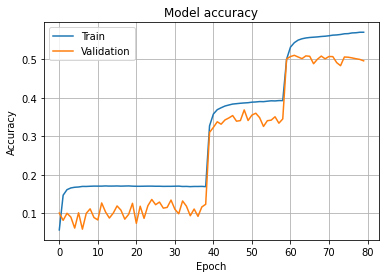

In [3]:
import matplotlib.pyplot as plt
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train',  'Validation'], loc='upper left')
plt.show()